<div align="center" class="alert alert-info" role="alert">
    <h1>
        Подбор подходящего пользователю тарифа сотовой связи
        <br>
        <small class="text-muted">учебный проект по теме "Введение в машинное обучение"</small>
    </h1>
</div>

<div align="right" class="alert alert-info" role="alert">
    <h3>Евгения Хомякова, 2020/12</h3>
</div>

### Описание проекта
**Бизнес-задача:** оператор мобильной связи хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф вместо архивного: «Смарт» или «Ультра».

**Данные:** предобработанные данные о поведении клиентов, которые уже перешли на эти тарифы.

**Задача проекта:** построение модели для задачи **классификации**, которая выберет подходящий тариф.


### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

----

<a name="table_of_contents"></a>

### Оглавление

0. [Импорт библиотек  и данных](#import)
1. [Разделение данных на train и test](#traintestsplit)
2. [Стратегия кросс-валидации и метрики качества модели](#cv)
3. [Бейзлайн](#baseline)
4. [Подбор гиперпараметров случайного леса](#gridsearch)
5. [Проверка модели на адекватность](#sanitycheck)
6. [Выводы](#conclusions)

<a name="import"></a>
## 0. Импорт библиотек  и данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
RS = 42

In [3]:
sns.set_palette('Paired')
sns.set_style('whitegrid',
              {'axes.facecolor': '1',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0.2',
               'text.color': '0.2',
               'xtick.color': '0.2',
               'ytick.color': '0.2',
               'grid.color': '0.7',
               'figure.facecolor': '0.95',}
             )

sns.set_context('notebook', font_scale=1.3)

plt.rcParams.update({
    'legend.fancybox': True,
    'legend.fontsize': 14,
    'legend.framealpha': 0.8,
    'legend.frameon': True,
    'legend.shadow': True,
    'legend.title_fontsize': 15,
    'figure.figsize': (10, 6)
})

In [4]:
users = pd.read_csv('datasets/users_behavior.csv')

In [5]:
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
users.duplicated().sum()

0

[вернуться к оглавлению](#table_of_contents)

<a name="traintestsplit"></a>
## 1. Разделение данных на train и test
Проверять качество на отложенной выборке - не здорово. Лучше делать это на кросс-валидации. Поэтому просто делим данные на train и test:

In [8]:
X = users.drop(['is_ultra'], axis=1) # матрица признаков
y = users['is_ultra'] # целевая переменная (метка класса)

In [9]:
y.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Классы несбалансированы, будем учитываеть это при построении модели.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,
                                                    random_state=RS, shuffle=True)

Посмотрим, как выглядят объекты в двумерном пространстве. Для этого сделаем понижение размерности и изобразим классы на графиках:

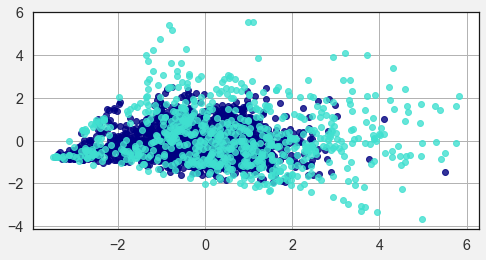

In [11]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_train_decomp = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,4))
plt.scatter(X_train_decomp[y_train == 0, 0],X_train_decomp[y_train == 0, 1],
            color='navy', alpha=.8)
plt.scatter(X_train_decomp[y_train == 1, 0],X_train_decomp[y_train == 1, 1],
            color='turquoise', alpha=.8)
plt.show()

Видим, что пространственно признаки сложно разделимы, вероятно, линейные модели будут работать плохо.

[вернуться к оглавлению](#table_of_contents)

<a name="cv"></a>
## 2. Стратегия кросс-валидации и метрики качества модели
Будем делить на 3 фолда с учетом того, что классы у нас несбалансированы:

In [12]:
# стратегия кросс-валидации
NFOLDS = 3
SKF = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

Оценивать качество классификации несбалансированной выборки по `accuracy` - так себе затея, но так так в задании требуется, то сделаем. На самом деле хорошо использовать `f1_score`:

In [13]:
# метрики для крос-валидации
scorers = ('f1','accuracy')

In [14]:
def get_cv_results(pipeline, X_train, y_train, cv=None, scorers=None):
    '''
    делает кросс-валидацию пайплайна, считая несколько метрик
    записывает результаты  в датафрейм и возвращает средние значения метрик для трейна и теста
    '''
    cv_res = cross_validate(pipeline, X_train, y_train,
                            cv=cv, scoring=scorers, return_train_score=True)
    cv_res = pd.DataFrame.from_dict(cv_res)[['test_f1','train_f1', 'test_accuracy','train_accuracy']]
    mean_res = cv_res.mean(axis=0)
    std_res = cv_res.std(axis=0)
    result = np.round(pd.concat([mean_res, std_res], axis=1), 3)
    result.columns = ['mean', 'std dev']

    return result

[вернуться к оглавлению](#table_of_contents)

<a name="baseline"></a>
## 3. Бейзлайн
Признаки хорошо бы стандартизировать, так как признаки измеряются в очень разных масштабах:

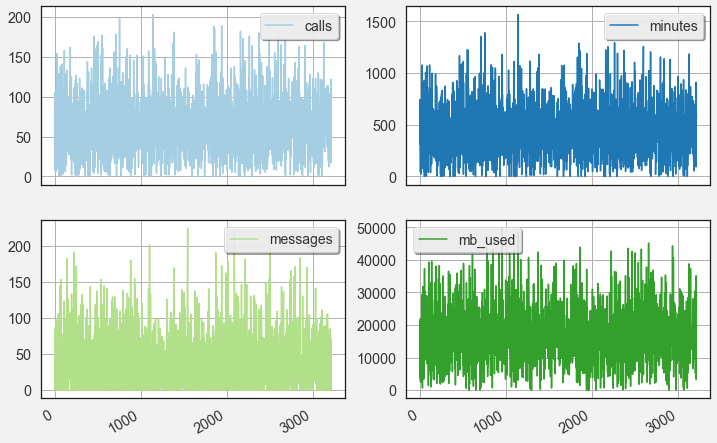

In [15]:
X_train.sort_index().plot(subplots=True, layout=(2,2), figsize=(12,8))
plt.show()

Определим два пайплайна для двух классификаторов - **Логистической регрессии** и **Случайного леса**, с параметрами по умолчанию - это будут наши *бейзлайны*. Оценим метрики качества этих пайплайнов *на кросс-валидации*:

In [16]:
logreg_clf_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('logreg', LogisticRegression(n_jobs=-1))
])
logreg_result = get_cv_results(logreg_clf_pipeline, X_train, y_train, cv=SKF, scorers=scorers)
logreg_result

,mean,std dev
test_f1,0.330,0.018
train_f1,0.346,0.025
test_accuracy,0.742,0.004
train_accuracy,0.747,0.007


Видим, что при `accuracy` 0.74 на кроссвалидации `f1_score` всего 0.33!

In [17]:
rf_clf_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('rf', RandomForestClassifier(n_jobs=-1))
])
rf_result = get_cv_results(rf_clf_pipeline, X_train, y_train, cv=SKF, scorers=scorers)
rf_result

,mean,std dev
test_f1,0.630,0.007
train_f1,1.000,0.000
test_accuracy,0.799,0.006
train_accuracy,1.000,0.000


Видим, насколько качественнее обучается лес и показывает лучшее качество на кросс-валидации.

[вернуться к оглавлению](#table_of_contents)

<a name="gridsearch"></a>
## 4. Подбор гиперпараметров случайного леса
Так как признаков и данных немного, нас не очень смущает время обучения леса, поэтому попробуем теперь настроить гиперпараметры для него. Подбирать гиперпараметры будем поиском по сетке с оценкой метрики `f1` на кросс-валидации. Так же укажем параметр `class_weight='balanced'`, так как классы несбалансированы:

In [18]:
# классификатор
rf_clf_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('rf', RandomForestClassifier(random_state=RS, n_jobs=-1))
])

# сетка параметров
param_grid = {
    'rf__n_estimators': np.arange(10,500,50),
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [6,10,15,20],
    'rf__class_weight': [None, 'balanced']
    # не очень хорошо знаю, до какого соотношения на баланс можно не смотреть особо
}


In [19]:
%%time
rf_cv_f1 = GridSearchCV(rf_clf_pipeline, param_grid, cv=SKF, scoring='f1', verbose=0)
rf_cv_f1.fit(X_train, y_train)

Wall time: 3min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [6, 10, 15, 20],
                         'rf__n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
             scoring='f1')

In [20]:
print('Лучшие по f1 параметры:', rf_cv_f1.best_params_)
print('Лучший f1_score (cv):', round(rf_cv_f1.best_score_,2))
print('f1_score на test:', round(rf_cv_f1.score(X_test, y_test),2))

Лучшие по f1 параметры: {'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__n_estimators': 410}
Лучший f1_score (cv): 0.64
f1_score на test: 0.65


Посмотрим на `accuracy` такого классификатора:

In [21]:
best_rf_f1 = rf_cv_f1.best_estimator_
round(accuracy_score(best_rf_f1.predict(X_test), y_test), 2)

0.81

Отлично!

Попробуем настроить гиперпараметры на `accuracy`:

In [22]:
%%time
rf_clf_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('rf', RandomForestClassifier(random_state=RS, n_jobs=-1))
])
rf_cv_acc = GridSearchCV(rf_clf_pipeline, param_grid, cv=SKF, scoring='accuracy', verbose=0)
rf_cv_acc.fit(X_train, y_train)

Wall time: 3min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [6, 10, 15, 20],
                         'rf__n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
             scoring='accuracy')

In [23]:
print('Лучшие по accuracy параметры:', rf_cv_acc.best_params_)
print('Лучший accuracy _score (cv):', round(rf_cv_acc.best_score_, 2))
print('accuracy_score на test:', round(rf_cv_acc.score(X_test, y_test), 2))

Лучшие по accuracy параметры: {'rf__class_weight': None, 'rf__criterion': 'entropy', 'rf__max_depth': 15, 'rf__n_estimators': 110}
Лучший accuracy _score (cv): 0.81
accuracy_score на test: 0.81


Посмотрим на `f1` такого классификатора:

In [24]:
best_rf_acc = rf_cv_acc.best_estimator_
round(f1_score(best_rf_acc.predict(X_test), y_test), 2)

0.64

**В данном случае разницы на что настраивавть гиперпараметры практически нет. То есть модель справляется с таким соотношением классов (1/2).**

[вернуться к оглавлению](#table_of_contents)

<a name="sanitycheck"></a>
## 5. Проверка модели на адекватность
Убедимся, что построенная модель лучше, чем случайная или константная модели:

In [25]:
y_model_predictions = best_rf_f1.predict(X_test)
y_constant_0 = [0]*len(y_test)
y_constant_1 = [1]*len(y_test)
y_random = np.random.choice([0, 1], size=len(y_test), p=[.5, .5])

In [26]:
print('f1_score на test для построенной модели:', round(f1_score(y_model_predictions, y_test), 2))
print('f1_score на test для констатной модели (0):', round(f1_score(y_constant_0, y_test), 2))
print('f1_score на test для констатной модели (1):', round(f1_score(y_constant_1, y_test), 2))
print('f1_score на test для модели со случайным ответом:', round(f1_score(y_random, y_test), 2))

f1_score на test для построенной модели: 0.65
f1_score на test для констатной модели (0): 0.0
f1_score на test для констатной модели (1): 0.47
f1_score на test для модели со случайным ответом: 0.4


[вернуться к оглавлению](#table_of_contents)

<a name="colclusions"></a>
## 6. Выводы

1. Построена оптимальная модель для классификации пользователей с целью подбора для них подходящего тарифа.
2. Были опробованы две модели: логистическая регрессия и случайный лес, реализованные в библиотеке sklearn.
3. Случайный лес на предоставленных данных показал лучший результат (для параметров по умолчанию f1_score (accuracy) при оценке по кросс-валидации равно 0.62 (0.79)).
4. При поиске по сетке гиперпараметров (с максимизацией `f1_score`) были найдены оптимальные: `'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 360`. Качество модели f1_score (accuracy) с оптимальными гипрепараметрами на кросс-валидации 0.64, на тестовой выборке - 0.65 (0.81).
5. При максимизации `accuracy` при поиске по сетке параметры сильно отличаются: `'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 110`, `accuracy` на тесте при этом 0.83 (чуть выше), `f1` на тесте 0.65 (такое же).
6. Вследствие того, что метрика `f1` при максимизации и `f1`, и `accuracy` примерно одинакова (0.65), можно сделать вывод что дисбаланс классов примерно 2 раза не критичен для построенной модели.
7. Модель была проверена на адекватность (sanity check): `f1_score` для констатной модели, которая на всех объектах выдает 0 - 0.0, 1 - 0.47, для модели со случайным ответом - 0.35.